### データのアップロード
振り分けた画像をzipファイルとして、Google Colab環境にアップロードします。
あらかじめ、zipファイルはGoogle Driveにアップロードしています。

In [0]:
from google.colab import drive

# マイドライブをマウント
drive.mount('/content/drive')

下記コマンドで、カレントディレクトリにコピーし、解凍します。

In [0]:
cp ../content/drive/My\ Drive/obama_and_smalling.zip ./

In [0]:
!unzip ./obama_and_smalling.zip

Google Colabに移ったので、ディレクトリ名を入れた変数をもう一度用意しておきます。

In [0]:
import os
base_dir     = './obama_and_smalling/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')
train_smalling = os.path.join(train_dir, 'smalling')
valid_smalling = os.path.join(valid_dir, 'smalling')
test_smalling  = os.path.join(test_dir, 'smalling')
train_obama   = os.path.join(train_dir, 'obama')
valid_obama   = os.path.join(valid_dir, 'obama')
test_obama    = os.path.join(test_dir, 'obama')

### 訓練画像の水増し
訓練画像が少ないと過学習してしまうので、kerasの`ImageDataGenerator`をつかって水増しを行います。以下のように回転させたり、シフトさせたり、ズームしたりして、画像を水増しするようです。

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pylab as plt

# 水増し用ジェネレータ
datagen = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# スモーリングの訓練画像リスト
smalling_face = [os.path.join(train_smalling, face) for face in os.listdir(train_smalling)]

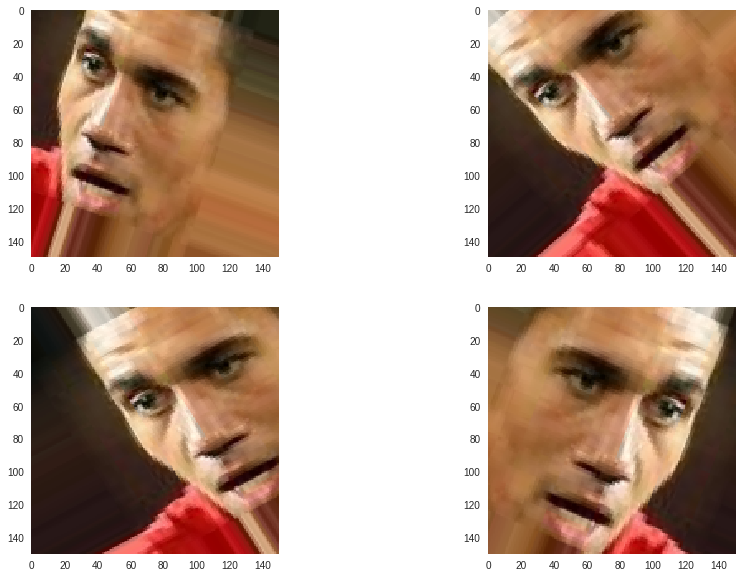

In [21]:
# 100枚目を元にする
img_path = smalling_face[99]

# 画像を(150, 150, 3) のnumpy arrayに変換
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)

# (1, 150, 150, 3)に整形
x = x.reshape((1,) + x.shape)

i = 0
fig = plt.figure(figsize=(15, 10))
for batch in datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(2, 2, i+1) # 2*2= 4枚まで
    ax.grid(False)
    imgplot = ax.imshow(image.array_to_img(batch[0]))
    i += 1
    # ジェネレータなので、どこかでbreakする必要がある
    if i == 4:
        break

plt.show()

### モデル構築
今回学習させるCNNを構築します。

In [0]:
from keras import  layers, models, optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # 過学習抑制のために、全結合層の前にDropout層を追加
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # 二値に分類するため
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

一応可視化(？)するとこんな感じです。

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
cp ./model.png ../content/drive/My\ Drive/

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### モデルの学習
ジェネレータを使って、モデルを学習させていきます。

In [37]:
# 訓練データは水増し
train_datagen = ImageDataGenerator(
    rescale=1./255, # 正規化
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 訓練データ以外は水増ししないこと！
test_datagen = ImageDataGenerator(rescale=1./255)


# 訓練データの画像を読み込み
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150), # 画像サイズを（150, 150）に変換
        batch_size=26,                 # バッチサイズ。慣習として2のべき乗とすることが多いらしいが、、
        class_mode='binary')       # 二値分類

# 検証データの画像を読み込み
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

# ジェネレータを使ったモデルの学習
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10, # 1エポック内でミニバッチを回す回数
      epochs=500,                 # エポック数（100と500で試しています）
      validation_data=validation_generator, # 検証用ジェネレータを指定
      validation_steps=50)                              # 検証を何エポックするか（？）

Found 259 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/500
10/10 [==============================] - 3s 266ms/step - loss: 0.6939 - acc: 0.5094 - val_loss: 0.7102 - val_acc: 0.5000
Epoch 2/500
10/10 [==============================] - 2s 227ms/step - loss: 0.6911 - acc: 0.5446 - val_loss: 0.6843 - val_acc: 0.5000
Epoch 3/500
10/10 [==============================] - 2s 234ms/step - loss: 0.6886 - acc: 0.5171 - val_loss: 0.6707 - val_acc: 0.6500
Epoch 4/500
10/10 [==============================] - 2s 233ms/step - loss: 0.6877 - acc: 0.5905 - val_loss: 0.6591 - val_acc: 0.7100
Epoch 5/500
10/10 [==============================] - 2s 233ms/step - loss: 0.6671 - acc: 0.6565 - val_loss: 0.6357 - val_acc: 0.8200
Epoch 6/500
10/10 [==============================] - 2s 231ms/step - loss: 0.6520 - acc: 0.6372 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 7/500
10/10 [==============================] - 2s 229ms/step - loss: 0.6504 - acc: 0.6136 - val_loss: 0.6494 - val

学習の過程はこんな感じ。順調ではないでしょうか。
* 100epochの場合

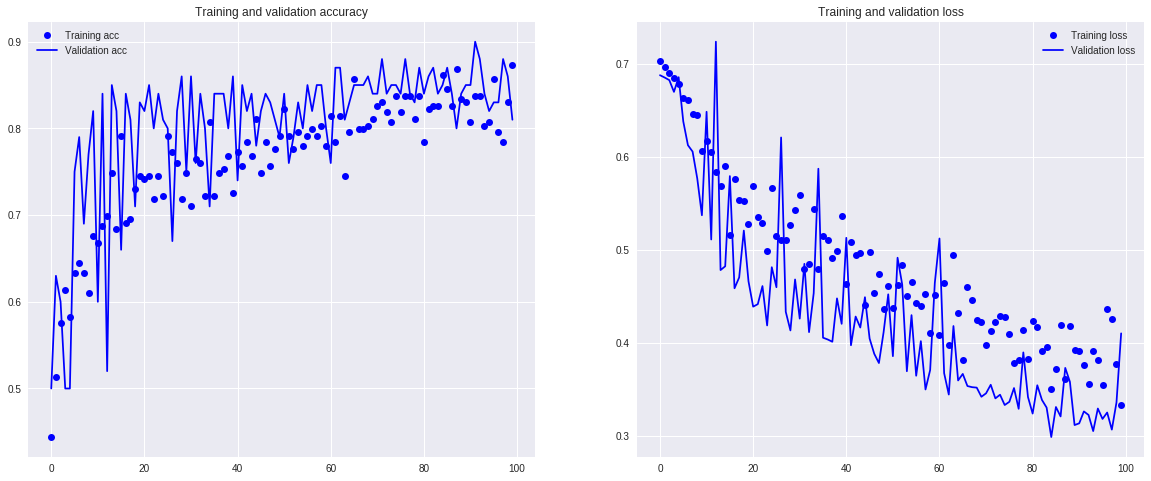

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 500epochの場合

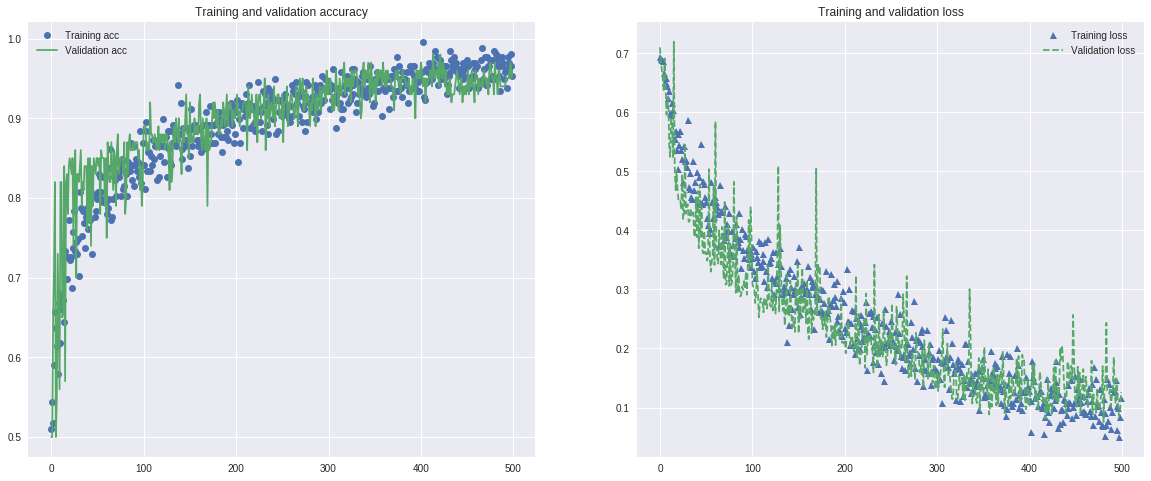

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'o', label='Training acc')
plt.plot(epochs, val_acc, '-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)

plt.plot(epochs, loss, '^', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### モデルの保存
学習したモデルを保存しておきます。保存したファイルは、マイドライブにコピーします。

In [0]:
model.save('obama_smalling_20190110.h5')

In [0]:
cp ./obama_smalling_20190110.h5 ../content/drive/My\ Drive/

### モデルの評価
まず、evaluate_generatorをつかって、精度を評価します。

In [56]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=18,
        class_mode='binary')

Found 125 images belonging to 2 classes.


In [57]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=20)
print('test acc:', test_acc)

test acc: 0.9692737388544242


### モデルによる予測
実際に、画像を読み込んで予測させてみます。

In [0]:
from PIL import Image
import numpy as np

def obama_smalling_predictor(image_path):
  img = Image.open(image_path).convert('RGB')
  img = img.resize((150, 150))
  
  x = np.array(img, dtype=np.float32)
  x = x / 255.
  x = x.reshape((1,) + x.shape)

  pred = model.predict(x, batch_size=1, verbose=0)
  score = np.max(pred)
  pred_label = np.argmax(pred)
  # 予測値に表示
  if(score >= 0.5):
    print('[Smalling] {:.4%} Sure.'.format(score))
  else:
    print('[Obama] {:.4%} Sure.'.format(1-score))
  # 画像の表示
  plt.imshow(img)
  plt.grid(False)

In [0]:
sample_smalling = './obama_and_smalling/test/smalling/0022_1.jpg'
sample_obama   = './obama_and_smalling/test/obama/0011_1.jpg'

[Smalling] 99.9015% Sure.


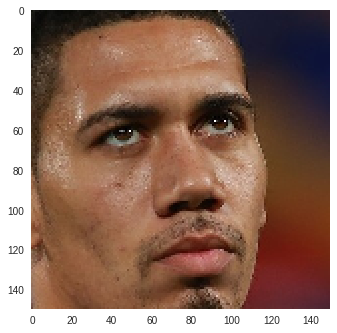

In [91]:
# テストデータのスモーリング画像から予測
obama_smalling_predictor(image_path=sample_smalling)

[Obama] 99.9045% Sure.


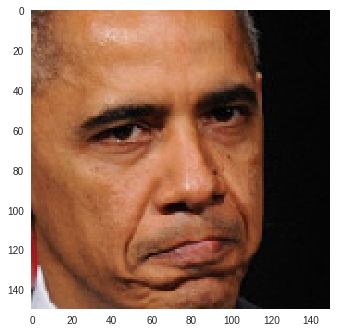

In [92]:
# テストデータのオバマ画像から予測
obama_smalling_predictor(image_path=sample_obama)

### 例の画像を予測！！
マグカップにプリントされてしまった顔写真を予測してみます。これが目的です！
とりあえずマイドライブに入れておいたので、コピーして予測します。

In [0]:
cp ../content/drive/My\ Drive/Obama_or_Smalling.jpg ./

[Obama] 99.9933% Sure.


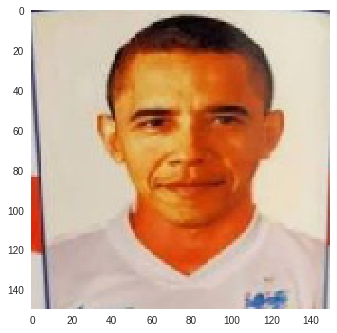

In [93]:
my_target = './Obama_or_Smalling.jpg'
obama_smalling_predictor(image_path=my_target)